In [0]:
# Import Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, split
from functools import reduce 
from pyspark.sql import functions as F
from pyspark.sql.functions import year, month, dayofmonth, dayofweek, dayofyear, weekofyear
from pyspark.sql.types import LongType

In [0]:
# Load file JSON
file_path = "s3://full-stack-bigdata-datasets/Big_Data/Project_Steam/steam_game_output.json"
df = spark.read.format('json').load(file_path, multiline=True)

In [0]:
#calculate the number of rows and columns
df.count(), len(df.columns)

(55691, 2)

In [0]:
df.printSchema()

root
 |-- data: struct (nullable = true)
 |    |-- appid: long (nullable = true)
 |    |-- categories: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- ccu: long (nullable = true)
 |    |-- developer: string (nullable = true)
 |    |-- discount: string (nullable = true)
 |    |-- genre: string (nullable = true)
 |    |-- header_image: string (nullable = true)
 |    |-- initialprice: string (nullable = true)
 |    |-- languages: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- negative: long (nullable = true)
 |    |-- owners: string (nullable = true)
 |    |-- platforms: struct (nullable = true)
 |    |    |-- linux: boolean (nullable = true)
 |    |    |-- mac: boolean (nullable = true)
 |    |    |-- windows: boolean (nullable = true)
 |    |-- positive: long (nullable = true)
 |    |-- price: string (nullable = true)
 |    |-- publisher: string (nullable = true)
 |    |-- release_date: string (nullable = true)
 |    |-

In [0]:
# Flatten the data structure
df_clean = df.select("id", "data.*")
df_clean.printSchema()

root
 |-- id: string (nullable = true)
 |-- appid: long (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ccu: long (nullable = true)
 |-- developer: string (nullable = true)
 |-- discount: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- header_image: string (nullable = true)
 |-- initialprice: string (nullable = true)
 |-- languages: string (nullable = true)
 |-- name: string (nullable = true)
 |-- negative: long (nullable = true)
 |-- owners: string (nullable = true)
 |-- platforms: struct (nullable = true)
 |    |-- linux: boolean (nullable = true)
 |    |-- mac: boolean (nullable = true)
 |    |-- windows: boolean (nullable = true)
 |-- positive: long (nullable = true)
 |-- price: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- required_age: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- tags: struct (nul

# Cleaning

### Prices

In [0]:
# Conversion prices in integer

df_clean = df_clean.withColumn("price", F.col("price").cast("int") / 100) \
                   .withColumn("initialprice", F.col("initialprice").cast("int") / 100)

In [0]:
# Verify the prices and discounts

df_clean = df_clean.withColumn(
    "calc_discount",
    F.when(F.col("initialprice") > 0,
           ((F.col("initialprice") - F.col("price")) / F.col("initialprice") * 100)
    ).otherwise(None)  # None (NULL) si gratuit
)

df_clean.select("name", "initialprice", "price", "discount", "calc_discount").show(15, truncate=False)


+------------------------------------+------------+-----+--------+-----------------+
|name                                |initialprice|price|discount|calc_discount    |
+------------------------------------+------------+-----+--------+-----------------+
|Counter-Strike                      |9.99        |9.99 |0       |0.0              |
|ASCENXION                           |9.99        |9.99 |0       |0.0              |
|Crown Trick                         |19.99       |5.99 |70      |70.03501750875436|
|Cook, Serve, Delicious! 3?!         |19.99       |19.99|0       |0.0              |
|细胞战争                            |1.99        |1.99 |0       |0.0              |
|Zengeon                             |19.99       |7.99 |60      |60.03001500750374|
|干支セトラ　陽ノ卷｜干支etc.　陽之卷|12.99       |12.99|0       |0.0              |
|Jumping Master(跳跳大咖)            |0.0         |0.0  |0       |NULL             |
|Cube Defender                       |2.99        |2.99 |0       |0.0              |
|Tow

### Languages

In [0]:
# Languages in array
df_clean = df_clean.withColumn("languages_array", F.split(F.col("languages"), ", "))


### Plateforms

In [0]:

df_clean = df_clean.withColumn("windows", F.col("platforms.windows")) \
                   .withColumn("mac", F.col("platforms.mac")) \
                   .withColumn("linux", F.col("platforms.linux"))

df_clean = df_clean.drop("platforms")
df_clean.printSchema()

root
 |-- id: string (nullable = true)
 |-- appid: long (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ccu: long (nullable = true)
 |-- developer: string (nullable = true)
 |-- discount: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- header_image: string (nullable = true)
 |-- initialprice: double (nullable = true)
 |-- languages: string (nullable = true)
 |-- name: string (nullable = true)
 |-- negative: long (nullable = true)
 |-- owners: string (nullable = true)
 |-- positive: long (nullable = true)
 |-- price: double (nullable = true)
 |-- publisher: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- required_age: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- tags: struct (nullable = true)
 |    |-- 1980s: long (nullable = true)
 |    |-- 1990's: long (nullable = true)
 |    |-- 2.5D: long (nullable = true)
 |    |-- 2D: long (nullable = true)

### Dates

In [0]:
# 1. Conserver la date brute
df_clean = df_clean.withColumn("release_date_raw", F.col("release_date"))

# 2. Nettoyer les vides → None
df_clean = df_clean.withColumn(
    "release_date_raw",
    F.when((F.col("release_date_raw").isNull()) | (F.col("release_date_raw") == ""), None)
     .otherwise(F.col("release_date_raw"))
)

# 3. Extraire année et mois en numérique
df_clean = df_clean.withColumn(
    "release_year",
    F.regexp_extract("release_date_raw", r"^(\d{4})", 1).cast("int")
)

df_clean = df_clean.withColumn(
    "release_month",
    F.regexp_extract("release_date_raw", r"^\d{4}/(\d{1,2})", 1).cast("int")
)

# 4. Créer une date approximative (toujours jour = 1)
df_clean = df_clean.withColumn(
    "release_date",
    F.when(
        (F.col("release_year").isNotNull()) & (F.col("release_month").isNotNull()),
        F.to_date(
            F.concat_ws(
                "-",
                F.col("release_year"),
                F.lpad(F.col("release_month").cast("string"), 2, "0"),  # mois toujours sur 2 chiffres
                F.lit("01")
            ),
            "yyyy-MM-dd"
        )
    )
)

# 5. Colonne pratique au format yyyy-MM pour les groupBy
df_clean = df_clean.withColumn(
    "release_year_month",
    F.when(
        (F.col("release_year").isNotNull()) & (F.col("release_month").isNotNull()),
        F.concat_ws(
            "-",
            F.col("release_year"),
            F.lpad(F.col("release_month").cast("string"), 2, "0")
        )
    )
)


In [0]:
df_clean.select(
    "release_date_raw", "release_year", "release_month", "release_date", "release_year_month"
).show(30, truncate=False)


+----------------+------------+-------------+------------+------------------+
|release_date_raw|release_year|release_month|release_date|release_year_month|
+----------------+------------+-------------+------------+------------------+
|2000/11/1       |2000        |11           |2000-11-01  |2000-11           |
|2021/05/14      |2021        |5            |2021-05-01  |2021-05           |
|2020/10/16      |2020        |10           |2020-10-01  |2020-10           |
|2020/10/14      |2020        |10           |2020-10-01  |2020-10           |
|2019/03/30      |2019        |3            |2019-03-01  |2019-03           |
|2019/06/24      |2019        |6            |2019-06-01  |2019-06           |
|2019/01/24      |2019        |1            |2019-01-01  |2019-01           |
|2019/04/8       |2019        |4            |2019-04-01  |2019-04           |
|2019/01/6       |2019        |1            |2019-01-01  |2019-01           |
|2021/09/9       |2021        |9            |2021-09-01  |2021-0

### Owner

In [0]:
# Clean and separate min/max
df_clean = df_clean.withColumn(
    "owners_min",
    F.regexp_replace(F.split(F.regexp_replace("owners", " ", ""), r"\.\.").getItem(0), ",", "").cast(LongType())
).withColumn(
    "owners_max",
    F.regexp_replace(F.split(F.regexp_replace("owners", " ", ""), r"\.\.").getItem(1), ",", "").cast(LongType())
)

# Mean
df_clean = df_clean.withColumn(
    "owners_mean",
    ((F.col("owners_min") + F.col("owners_max")) / 2).cast(LongType())
)
# Drop
df_clean = df_clean.drop("owners")

# Checking
df_clean.select("name", "owners_min", "owners_max", "owners_mean").show(10, truncate=False)


+------------------------------------+----------+----------+-----------+
|name                                |owners_min|owners_max|owners_mean|
+------------------------------------+----------+----------+-----------+
|Counter-Strike                      |10000000  |20000000  |15000000   |
|ASCENXION                           |0         |20000     |10000      |
|Crown Trick                         |200000    |500000    |350000     |
|Cook, Serve, Delicious! 3?!         |100000    |200000    |150000     |
|细胞战争                            |0         |20000     |10000      |
|Zengeon                             |100000    |200000    |150000     |
|干支セトラ　陽ノ卷｜干支etc.　陽之卷|0         |20000     |10000      |
|Jumping Master(跳跳大咖)            |20000     |50000     |35000      |
|Cube Defender                       |0         |20000     |10000      |
|Tower of Origin2-Worm's Nest        |0         |20000     |10000      |
+------------------------------------+----------+----------+-----------+
on

### Genres

In [0]:
# 1. Transformer "genre" en array
df_clean = df_clean.withColumn(
    "genres_array",
    split(F.col("genre"), ",\s*") # split sur virgule + espaces
    )
# 2. Vérification
df_clean.select("name", "genre", "genres_array").show(10, truncate=False)

# 3. Version explosée (un jeu = plusieurs lignes si plusieurs genres)
df_genres = df_clean.withColumn("genre_exploded", explode("genres_array"))

# 4. Vérification
df_genres.select("name", "genre_exploded").show(20, truncate=False)

+------------------------------------+--------------------------------------------------------------+----------------------------------------------------------------+
|name                                |genre                                                         |genres_array                                                    |
+------------------------------------+--------------------------------------------------------------+----------------------------------------------------------------+
|Counter-Strike                      |Action                                                        |[Action]                                                        |
|ASCENXION                           |Action, Adventure, Indie                                      |[Action, Adventure, Indie]                                      |
|Crown Trick                         |Adventure, Indie, RPG, Strategy                               |[Adventure, Indie, RPG, Strategy]                               

### Categories

In [0]:
df_clean.select(explode("categories").alias("category")) \
    .groupBy("category") \
    .count() \
    .orderBy(F.desc("count")) \
    .show(20, truncate=False)


+--------------------------+-----+
|category                  |count|
+--------------------------+-----+
|Single-player             |52025|
|Steam Achievements        |27394|
|Steam Cloud               |14235|
|Full controller support   |11879|
|Multi-player              |11455|
|Steam Trading Cards       |9208 |
|Partial Controller Support|7867 |
|PvP                       |7070 |
|Co-op                     |5616 |
|Steam Leaderboards        |5509 |
|Online PvP                |5025 |
|Remote Play Together      |4860 |
|Shared/Split Screen       |4324 |
|Shared/Split Screen PvP   |3125 |
|Online Co-op              |2981 |
|Stats                     |2926 |
|Shared/Split Screen Co-op |2450 |
|Remote Play on TV         |1941 |
|Cross-Platform Multiplayer|1742 |
|Includes level editor     |1657 |
+--------------------------+-----+
only showing top 20 rows


In [0]:
df_categories = df_clean.withColumn("category_exploded", explode("categories"))


In [0]:
df_categories.select("name", "category_exploded").show(10, truncate=False)


+--------------+--------------------------+
|name          |category_exploded         |
+--------------+--------------------------+
|Counter-Strike|Multi-player              |
|Counter-Strike|Valve Anti-Cheat enabled  |
|Counter-Strike|Online PvP                |
|Counter-Strike|Shared/Split Screen PvP   |
|Counter-Strike|PvP                       |
|ASCENXION     |Single-player             |
|ASCENXION     |Partial Controller Support|
|ASCENXION     |Steam Achievements        |
|ASCENXION     |Steam Cloud               |
|Crown Trick   |Single-player             |
+--------------+--------------------------+
only showing top 10 rows


### Tags

In [0]:
# Struct -> tableau clé-valeur -> explode
df_tags = df_clean.select(
    "id", "name",
    explode(F.map_entries("tags")).alias("tag_kv")
)

# Séparer clé (nom du tag) et valeur (score)
df_tags = df_tags.withColumn("tag", F.col("tag_kv.key")) \
                 .withColumn("score", F.col("tag_kv.value")) \
                 .drop("tag_kv")


In [0]:
df_tags = df_clean.select(
    "id", "name",
    explode(F.map_from_arrays(
        F.array(*[F.lit(c) for c in df_clean.select("tags.*").columns]),  # clés (noms des tags)
        F.array(*[F.col(f"tags.`{c}`") for c in df_clean.select("tags.*").columns])  # valeurs (scores)
    )).alias("tag", "score")
)


In [0]:
df_tags.show(20, truncate=False)


+---+--------------+--------------+-----+
|id |name          |tag           |score|
+---+--------------+--------------+-----+
|10 |Counter-Strike|1980s         |266  |
|10 |Counter-Strike|1990's        |1191 |
|10 |Counter-Strike|2.5D          |NULL |
|10 |Counter-Strike|2D            |NULL |
|10 |Counter-Strike|2D Fighter    |NULL |
|10 |Counter-Strike|2D Platformer |NULL |
|10 |Counter-Strike|360 Video     |NULL |
|10 |Counter-Strike|3D            |NULL |
|10 |Counter-Strike|3D Fighter    |NULL |
|10 |Counter-Strike|3D Platformer |NULL |
|10 |Counter-Strike|3D Vision     |NULL |
|10 |Counter-Strike|4 Player Local|NULL |
|10 |Counter-Strike|4X            |NULL |
|10 |Counter-Strike|6DOF          |NULL |
|10 |Counter-Strike|8-bit Music   |NULL |
|10 |Counter-Strike|ATV           |NULL |
|10 |Counter-Strike|Abstract      |NULL |
|10 |Counter-Strike|Action        |5426 |
|10 |Counter-Strike|Action RPG    |NULL |
|10 |Counter-Strike|Action RTS    |NULL |
+---+--------------+--------------

# Analysis

## Macro Analysis

### Which publisher has released the most games on Steam?

We have 132 missing values in the Publisher fields. The most active pUblisher is "Big Fish Games" with 422 games. We can see the top 20 in the barplot.

+--------------------------+-----+
|publisher                 |count|
+--------------------------+-----+
|Big Fish Games            |422  |
|8floor                    |202  |
|SEGA                      |165  |
|Strategy First            |151  |
|Square Enix               |141  |
|Choice of Games           |140  |
|HH-Games                  |132  |
|                          |132  |
|Sekai Project             |132  |
|Ubisoft                   |127  |
|Laush Studio              |126  |
|THQ Nordic                |125  |
|Alawar Entertainment      |107  |
|Fulqrum Publishing        |104  |
|Plug In Digital           |101  |
|Ziggurat                  |100  |
|Slitherine Ltd.           |99   |
|Sokpop Collective         |99   |
|Devolver Digital          |98   |
|KOEI TECMO GAMES CO., LTD.|90   |
+--------------------------+-----+
only showing top 20 rows


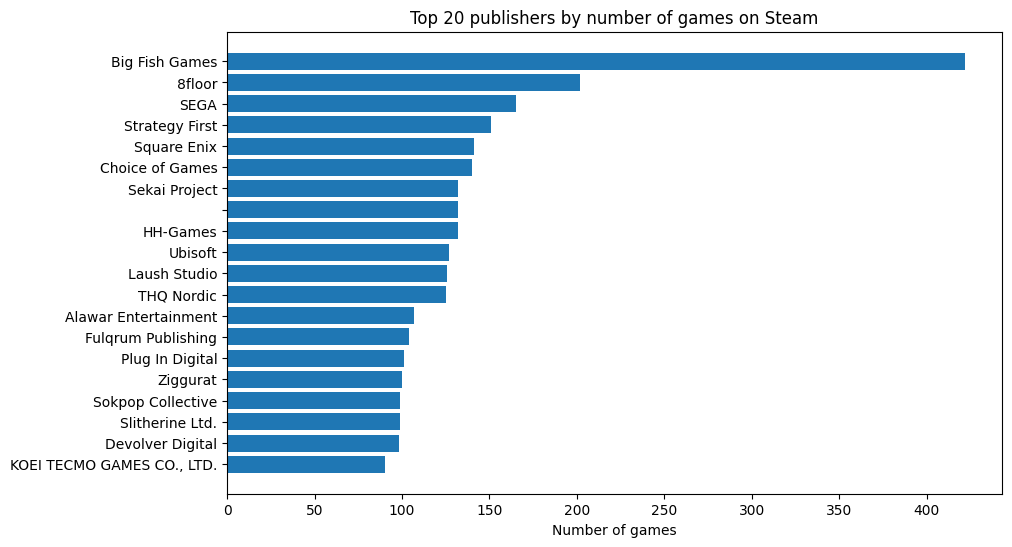

132

In [0]:
# 1. Count the number of games per publisher
df_clean.groupBy("publisher") \
    .count() \
    .orderBy(F.desc("count")) \
    .show(20, truncate=False)


# 2. Top publishers with the largest game catalog
import matplotlib.pyplot as plt

publisher_counts = df_clean.groupBy("publisher") \
    .count() \
    .orderBy(F.desc("count")) \
    .limit(20) \
    .toPandas()

plt.figure(figsize=(10,6))
plt.barh(publisher_counts["publisher"], publisher_counts["count"])
plt.gca().invert_yaxis()
plt.title("Top 20 publishers by number of games on Steam")
plt.xlabel("Number of games")
plt.show()


# 3. Check if there are missing publisher values
df_clean.filter((F.col("publisher").isNull()) | (F.col("publisher") == "")).count()


In [0]:
df_clean.filter((F.col("publisher").isNull()) | (F.col("publisher") == "")).count()


132

### Who are the most lucrative publishers?

The most lucrative Publisher is Ubisoft with a turnover on Steam estimatited at 3.48 billion euros since the years 2000 until 2023.

In [0]:
from pyspark.sql import functions as F

# Step 1: compute estimated revenue per game
df_revenue = df_clean.withColumn(
    "estimated_revenue",
    F.col("price") * F.col("owners_mean")
)

# Step 2: aggregate revenue by publisher
df_pub_revenue = (
    df_revenue.groupBy("publisher")
              .agg(F.sum("estimated_revenue").alias("total_revenue"))
              .orderBy(F.desc("total_revenue"))
              .limit(20)   # keep only top 20
)

# Step 3: display as a bar chart in Databricks
display(df_pub_revenue)


publisher,total_revenue
Ubisoft,3.4803004E9
Electronic Arts,3.188435E9
Valve,2.40048E9
Xbox Game Studios,2.25967235E9
Bethesda Softworks,2.21021685E9
"FromSoftware Inc., Bandai Namco Entertainment",2.09965E9
Rockstar Games,1.89251425E9
Paradox Interactive,1.8688846E9
SEGA,1.86423185E9
Activision,1.67836075E9


Databricks visualization. Run in Databricks to view.

### What are the best rated games?

The best rated game of all times in Steam is Counter Strike: Global Offensive

In my opinion, the weighted score method is more appropriate for this analysis. While the Wilson score provides a statistically rigorous lower bound, the weighted approach directly combines two key aspects of a game's performance: its rating ratio and the total number of reviews. The number of reviews is not only a sign of statistical reliability, but also an indicator of popularity. By correlating popularity with the rating given, the weighted score highlights games that are both highly appreciated and widely played, which aligns better with the goal of identifying the “best” games on Steam.

In [0]:
# Step 1: total reviews + ratio
df_ratings = df_clean.withColumn(
    "total_reviews", F.col("positive") + F.col("negative")
).withColumn(
    "positive_ratio", (F.col("positive") / F.col("total_reviews"))
)

# Filter: only keep games with > 100 reviews
df_ratings_filtered = df_ratings.filter(F.col("total_reviews") > 100)

# --- Method 1: Weighted score (ratio * log(n)) ---
df_weighted = df_ratings_filtered.withColumn(
    "score_weighted", (F.col("positive_ratio") * F.log(F.col("total_reviews")))
)

# --- Method 2: Wilson score lower bound ---
z = 1.96  # 95% confidence interval
df_wilson = df_weighted.withColumn(
    "wilson_score",
    (
        (F.col("positive_ratio") + (z**2) / (2*F.col("total_reviews"))
         - z * F.sqrt(
            (F.col("positive_ratio")*(1-F.col("positive_ratio"))/F.col("total_reviews"))
            + (z**2)/(4*F.col("total_reviews")**2)
         )
        ) / (1 + (z**2)/F.col("total_reviews"))
    )
)

# --- Top 10 by each method ---
df_top_weighted = df_wilson.orderBy(F.desc("score_weighted")).limit(10)
df_top_wilson   = df_wilson.orderBy(F.desc("wilson_score")).limit(10)

print("Top 10 games by Weighted Score:")
display(df_top_weighted.select("name", "publisher", "release_year", "total_reviews", "positive_ratio", "score_weighted"))

print("Top 10 games by Wilson Score:")
display(df_top_wilson.select("name", "publisher", "release_year", "total_reviews", "positive_ratio", "wilson_score"))


Top 10 games by Weighted Score:


name,publisher,release_year,total_reviews,positive_ratio,score_weighted
Counter-Strike: Global Offensive,Valve,2012,6730438,0.8830547135268165,13.883519354141658
Terraria,Re-Logic,2011,1037091,0.978420408623737,13.553011242219547
Garry's Mod,Valve,2006,891238,0.9663412017889722,13.239228905304396
Left 4 Dead 2,Valve,2009,660664,0.9745286560187932,13.059659171139732
Wallpaper Engine,Wallpaper Engine Team,2018,572127,0.9807193158162436,13.001510001629057
Euro Truck Simulator 2,SCS Software,2012,587983,0.9734431097497717,12.931659546180157
Stardew Valley,ConcernedApe,2016,506841,0.9816845914201889,12.895362284527993
The Witcher 3: Wild Hunt,CD PROJEKT RED,2015,657872,0.9616262738040227,12.882681845064091
Team Fortress 2,Valve,2007,903830,0.9364670347299824,12.843080287701115
Phasmophobia,Kinetic Games,2020,491098,0.968350512524995,12.689651468158655


Databricks visualization. Run in Databricks to view.

Top 10 games by Wilson Score:


name,publisher,release_year,total_reviews,positive_ratio,wilson_score
Flowers -Le volume sur ete-,JAST USA,2018,938,0.9989339019189766,0.9939858956201111
The Void Rains Upon Her Heart,The Hidden Levels,2018,496,1.0,0.9923143651908926
Aseprite,Igara Studio,2016,11903,0.9932790052927833,0.9916436422342876
A Short Hike,adamgryu,2019,11732,0.9925843845891579,0.9908625594880207
Senren＊Banka,"HIKARI FIELD, NekoNyan Ltd.",2020,10677,0.9921326215228997,0.9902707575882939
Aventura Copilului Albastru și Urât,Codrin Bradea,2021,2217,0.9936851601262968,0.9894277072590345
祈風 Inorikaze,觀象草圖 Astrolabe Draft,2019,327,1.0,0.9883884009749682
People Playground,Studio Minus,2019,144569,0.9885936819096763,0.9880331581603923
Portal 2,Valve,2011,309441,0.9878167405094994,0.9874241060255524
CULTIC,3D Realms,2022,2037,0.9921453117329406,0.9872784307691607


### Are there years with more releases? Were there more or fewer game releases during the Covid, for example?

2021 was the year with the more release (8823), right after covid. The covid year in 2020 is the second year with the most releases (8305).

In [0]:
# Step 1: count number of games per release year
df_releases_per_year = (
    df_clean.groupBy("release_year")
            .count()
            .orderBy("release_year")
)

# Step 2: display as a line chart in Databricks
display(df_releases_per_year)


release_year,count
null,99
1997,2
1998,1
1999,3
2000,2
2001,4
2002,1
2003,3
2004,6
2005,6


Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

### How are the prizes distributed?

Nearly half of the games are free, one quarter of them are around five euros and the other quarter is between 10 and 35 euros, only less than 500 games are above 35 euros.

In [0]:
# Count how many games for each price point
df_price_counts = (
    df_clean.groupBy("price")
            .count()
            .orderBy("price")
)

display(df_price_counts)


price,count
0.0,7780
0.28,20
0.29,11
0.3,2
0.31,6
0.37,19
0.38,7
0.39,7
0.41,10
0.44,1


Databricks visualization. Run in Databricks to view.

In [0]:
# Keep only games with a valid price (exclude NULLs and 0 if you want)
df_price_nonzero = df_clean.filter(
    (F.col("price").isNotNull()) & (F.col("price") > 0)
)

# Round price to nearest lower multiple of 5
df_price_nonzero = df_price_nonzero.withColumn(
    "price_bin",
    (F.floor(F.col("price") / 5) * 5)
)

# Aggregate counts per price bin
price_distribution = (
    df_price_nonzero.groupBy("price_bin")
    .count()
    .orderBy("price_bin")
)

# Show in Databricks (you can directly switch to histogram/bar chart)
display(price_distribution)


price_bin,count
0,23478
5,12450
10,5311
15,3711
20,910
25,884
30,162
35,438
40,47
45,192


Databricks visualization. Run in Databricks to view.

### Are there many games with a discount?

2518 games have a discount and 53173 don't.

In [0]:
# Create a boolean column "has_discount"
df_discount = df_clean.withColumn(
    "has_discount",
    F.col("price") < F.col("initialprice")
)

# Count how many games are discounted vs not
df_discount.groupBy("has_discount").count().show()


+------------+-----+
|has_discount|count|
+------------+-----+
|        true| 2518|
|       false|53173|
+------------+-----+



In [0]:
df_discount = df_discount.withColumn(
    "discount_pct",
    F.when(F.col("initialprice") > 0,
           ((F.col("initialprice") - F.col("price")) / F.col("initialprice")) * 100
    ).otherwise(None)   # set NULL if initialprice = 0
)


In [0]:
df_discount.groupBy("discount_pct").count().orderBy("discount_pct", ascending=False).show(200)


+------------------+-----+
|      discount_pct|count|
+------------------+-----+
| 90.22556390977444|    4|
| 90.18036072144288|  114|
| 90.15025041736227|   20|
| 90.12875536480688|   14|
| 90.11264080100125|    2|
| 90.10011123470522|    3|
| 90.09009009009009|   33|
| 90.08189262966333|    5|
| 90.07506255212677|    3|
| 90.06928406466513|    2|
| 90.06004002668445|    7|
| 90.05297233666863|    1|
| 90.04739336492891|    1|
| 90.04502251125564|   15|
| 90.03601440576232|    7|
| 90.03001000333445|    2|
| 90.02572163475278|    1|
|  90.0225056264066|    1|
|  90.0200044454323|    2|
| 90.01800360072014|    2|
| 89.17835671342685|    5|
| 89.12732474964234|    1|
| 89.05937291527685|    1|
| 88.17635270541082|    2|
| 87.29096989966555|    7|
| 87.21804511278197|   25|
|  87.1743486973948|    2|
|  87.1244635193133|    1|
| 87.08708708708708|    1|
|  86.2876254180602|   10|
| 86.14357262103506|    2|
| 86.04302151075538|    1|
| 85.21303258145365|    1|
| 85.17034068136272|    5|
|

In [0]:
# Keep only games with a non-null and non-zero discount
df_discount_nonzero = df_discount.filter(
    (F.col("discount_pct").isNotNull()) & (F.col("discount_pct") > 0)
)

# Round discounts to the nearest lower multiple of 5
df_discount_nonzero = df_discount_nonzero.withColumn(
    "discount_bin",
    (F.floor(F.col("discount_pct") / 5) * 5)
)

# Count how many games are in each discount bin
discount_distribution_nonzero = (
    df_discount_nonzero.groupBy("discount_bin")
    .count()
    .orderBy("discount_bin")
)

display(discount_distribution_nonzero)


discount_bin,count
10,54
15,50
20,120
25,88
30,151
35,46
40,168
45,53
50,498
55,29


Databricks visualization. Run in Databricks to view.

### What are the most represented languages?

The most represented language is English with 55 thousand games, then German, French, Russian, Chinese and Spanish between 12 and 14 thousand games.

In [0]:
# See the top 10 languages

df_lang = df_clean.withColumn("language", F.explode("languages_array"))
df_lang.groupBy("language").count().orderBy(F.desc("count")).show(10)

+-------------------+-----+
|           language|count|
+-------------------+-----+
|            English|55116|
|             German|14019|
|             French|13426|
|            Russian|12922|
| Simplified Chinese|12782|
|    Spanish - Spain|12233|
|           Japanese|10368|
|            Italian| 9304|
|Portuguese - Brazil| 6750|
|             Korean| 6599|
+-------------------+-----+
only showing top 10 rows


### Are there many games prohibited for children under 16/18?

There are 32 games prohibited for people under 12 years old, 38 for people under 16 years old and 223 for people under 18 years old. 

In [0]:
# Keep only digits from required_age (e.g., "MA 15+" -> "15")
df_age = df_clean.withColumn(
    "required_age_clean",
    F.regexp_extract(F.col("required_age"), r"(\d+)", 1)  # extract the first number found
)

# Cast to integer
df_age = df_age.withColumn("required_age_int", F.col("required_age_clean").cast("int"))

# Count games per age restriction
age_distribution = (
    df_age.groupBy("required_age_int")
    .count()
    .orderBy("required_age_int")
)

display(age_distribution)


required_age_int,count
0,55030
3,3
5,1
6,4
7,3
8,3
9,1
10,7
12,32
13,26


In [0]:
# 1. Extract numeric part (e.g., "MA 15+" -> "15")
df_age = df_clean.withColumn(
    "required_age_clean",
    F.regexp_extract(F.col("required_age"), r"(\d+)", 1)
)

# 2. Cast to integer
df_age = df_age.withColumn("required_age_int", F.col("required_age_clean").cast("int"))

# 3. Standardize to PEGI categories (0, 7, 10, 12, 16, 18)
df_age = df_age.withColumn(
    "required_age_pegi",
    F.when(F.col("required_age_int").isin(7, 10, 12, 16, 18), F.col("required_age_int"))
     .otherwise(F.lit(0))  # everything else considered "All public (0)"
)

# 4. Count games per PEGI category
age_distribution = (
    df_age.groupBy("required_age_pegi")
    .count()
    .orderBy("required_age_pegi")
)

# Filter out PEGI 0 (all public)
age_distribution_restricted = (
    df_age.filter(F.col("required_age_pegi") > 0)
          .groupBy("required_age_pegi")
          .count()
          .orderBy("required_age_pegi")
)

display(age_distribution_restricted)

required_age_pegi,count
7,3
10,7
12,32
16,38
18,223


Databricks visualization. Run in Databricks to view.

## Genres Analysis

### What are the most represented genres?

The most represented genres are "Indie" (39681 games), "Action" (23759 games), "Casual" (22086 games) and "Adventure" (21431).

In [0]:
# Top 10 genres the most represented
df_genres.groupBy("genre_exploded") \
    .count() \
    .orderBy(F.desc("count")) \
    .show(10, truncate=False)


+--------------+-----+
|genre_exploded|count|
+--------------+-----+
|Indie         |39681|
|Action        |23759|
|Casual        |22086|
|Adventure     |21431|
|Strategy      |10895|
|Simulation    |10836|
|RPG           |9534 |
|Early Access  |6145 |
|Free to Play  |3393 |
|Sports        |2666 |
+--------------+-----+
only showing top 10 rows


### Are there any genres that have a better positive/negative review ratio?

The best genres ratios are "Casual", "Indie" and "Adventure".

In [0]:
# 1. Compute review ratio per game
df_genres = df_genres.withColumn(
    "review_ratio",
    F.when((F.col("positive") + F.col("negative")) > 0,
           F.col("positive") / (F.col("positive") + F.col("negative")))
     .otherwise(None)
)

# 2. Aggregate by genre: average ratio + number of games
genre_review_ratio = (
    df_genres.groupBy("genre_exploded")
             .agg(F.avg("review_ratio").alias("avg_review_ratio"),
                  F.count("*").alias("game_count"))
             .orderBy(F.desc("avg_review_ratio"))
)

# 3. Display results
display(genre_review_ratio)


genre_exploded,avg_review_ratio,game_count
Casual,0.7433547943468957,22086
Indie,0.7420823279649753,39681
Adventure,0.7387596902445671,21431
Game Development,0.7377875884249145,159
RPG,0.7305758717429454,9534
Action,0.7300171420778402,23759
Accounting,0.7233369856008806,16
Free to Play,0.7218500120905411,3393
Design & Illustration,0.7207388387516215,406
Web Publishing,0.7196752177479993,89


### Do some publishers have favorite genres?

We can see in the list below the game count per publisher and per genre. For example the Publisher "Big Fish Games" has a game count of 418 for the genre "Calual" and 392 games for the genre "Adventure".

In [0]:
# Count games per publisher & genre
publisher_genres = (
    df_genres.groupBy("publisher", "genre_exploded")
    .count()
    .withColumnRenamed("count", "game_count")
)

display(publisher_genres.orderBy("game_count", ascending=False))


publisher,genre_exploded,game_count
Big Fish Games,Casual,418
Big Fish Games,Adventure,392
8floor,Casual,202
Choice of Games,RPG,139
Choice of Games,Indie,136
HH-Games,Casual,132
Laush Studio,Indie,124
Choice of Games,Adventure,112
,Indie,106
Alawar Entertainment,Casual,105


### What are the most lucrative genres?

Overall the 23 years that cover our study since the year 2000, the most lucrative genre is "Action", then "Adventure" and "Indie".

In [0]:
# Compute estimated revenue per game
df_revenue = df_clean.withColumn(
    "estimated_revenue",
    F.col("price") * F.col("owners_mean")
)

In [0]:
# Join with exploded genres
df_genres_revenue = df_genres.join(
    df_revenue.select("id", "estimated_revenue"),
    on="id",
    how="inner"
)


In [0]:
# Aggregate by genre
genre_revenue = (
    df_genres_revenue.groupBy("genre_exploded")
    .agg(F.sum("estimated_revenue").alias("total_revenue"))
    .orderBy(F.col("total_revenue").desc())
)

display(genre_revenue)


genre_exploded,total_revenue
Action,5.87564541E10
Adventure,3.724573845E10
Indie,3.23465771E10
RPG,2.71731431E10
Strategy,2.015004105E10
Simulation,1.876974955E10
Casual,8.08095665E9
Massively Multiplayer,5.93015775E9
Early Access,5.45866145E9
Sports,3.14989735E9


### What are the most used tags?

The most used tags corrolate the most lucrative genres with "Action" in first place, then "Adventure" and Indie.

In [0]:
df_tag_freq = df_tags.groupBy("tag") \
    .agg(F.sum("score").alias("total_score")) \
    .orderBy(F.desc("total_score"))

df_tag_freq.show(20, truncate=False)


+--------------+-----------+
|tag           |total_score|
+--------------+-----------+
|Action        |2911335    |
|Adventure     |2412383    |
|Indie         |2258563    |
|Singleplayer  |2169116    |
|Casual        |2007040    |
|2D            |1468241    |
|Strategy      |1398293    |
|RPG           |1322331    |
|Simulation    |1278811    |
|Multiplayer   |1211640    |
|Atmospheric   |1114826    |
|Exploration   |1022079    |
|Puzzle        |941809     |
|Shooter       |940868     |
|First-Person  |937493     |
|Story Rich    |933809     |
|3D            |919642     |
|Colorful      |826422     |
|Open World    |825726     |
|Pixel Graphics|809161     |
+--------------+-----------+
only showing top 20 rows


## Platform analysis

### Are most games available on Windows/Mac/Linux instead?

The games are mostly available on Windows (55676 out of 55691), then around one fourth of the games are available on Mac and then only 15% are available on Linux. 

In [0]:
# NUmber of games per platforms

df_clean.agg(
    F.sum(F.col("windows").cast("int")).alias("windows_count"),
    F.sum(F.col("mac").cast("int")).alias("mac_count"),
    F.sum(F.col("linux").cast("int")).alias("linux_count")
).show()


+-------------+---------+-----------+
|windows_count|mac_count|linux_count|
+-------------+---------+-----------+
|        55676|    12770|       8458|
+-------------+---------+-----------+



### Do certain genres tend to be preferentially available on certain platforms?

We can see that all genres and games are available on Windows as the largely most prefered platform.

In [0]:
# Aggregate counts of games per genre × platform
genre_platform = (
    df_genres.groupBy("genre_exploded")
    .agg(
        F.sum(F.when(F.col("windows") == True, 1).otherwise(0)).alias("windows_count"),
        F.sum(F.when(F.col("mac") == True, 1).otherwise(0)).alias("mac_count"),
        F.sum(F.when(F.col("linux") == True, 1).otherwise(0)).alias("linux_count"),
        F.countDistinct("id").alias("total_games")
    )
)

# Normalize to get platform share per genre
genre_platform_share = (
    genre_platform
    .withColumn("windows_share", F.col("windows_count") / F.col("total_games"))
    .withColumn("mac_share", F.col("mac_count") / F.col("total_games"))
    .withColumn("linux_share", F.col("linux_count") / F.col("total_games"))
    .orderBy(F.col("total_games").desc())
)

display(genre_platform_share)


genre_exploded,windows_count,mac_count,linux_count,total_games,windows_share,mac_share,linux_share
Indie,39676,9935,6978,39681,0.9998739951110103,0.2503717144225196,0.17585242307401527
Action,23755,4564,3379,23759,0.9998316427459069,0.19209562692032492,0.14221979039521865
Casual,22082,5130,3305,22086,0.9998188897944399,0.23227383863080683,0.14964230734401884
Adventure,21427,5039,3302,21431,0.9998133544864916,0.2351266856422939,0.15407587140124118
Strategy,10892,3005,1826,10895,0.9997246443322625,0.2758145938503901,0.16759981642955485
Simulation,10832,2439,1532,10836,0.9996308600959763,0.22508305647840532,0.14138058324104835
RPG,9533,2248,1524,9534,0.999895112229914,0.23578770715334593,0.15984896161107615
Early Access,6145,900,632,6145,1.0,0.14646053702196907,0.10284784377542718
Free to Play,3391,845,474,3393,0.999410551134689,0.24904214559386972,0.13969938107869143
Sports,2665,506,287,2666,0.9996249062265566,0.18979744936234058,0.10765191297824456


https://dbc-49fbcce6-e30f.cloud.databricks.com/editor/notebooks/120292151024905?o=2475765202477246